# Goal
Purpose of this notebook is to get a feeling of the regression performance of pixel sums when using simple NNs.

In [2]:
import keras
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.keras.backend.set_floatx('float64') # increases accuracy

# Ideal regression
A network of one neuron fully connected to $n\times n$ pixels of an input image is easily capable to learn regression of the sum of all pixel values. This is accomplished when the bias is 0 and all weights are 1. The only error comes due to choice of datatype, if we increase from float32 (default) to float64 we get better accuracy. We can directly see this below:

32/32 [==============================] - 0s 648us/step
27.23093 27.23093241781294


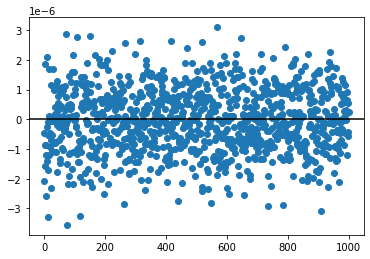

In [4]:
W = 7 # side length (width) of images
N = 1000 # no. samples
data = np.random.rand(N,W,W)
truth = np.sum(data, axis=(1,2)) # sum of all pixels in a image for all samples

model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)]) # a shallow model

model.get_weights()
model.set_weights([np.ones((W*W,1))])
pred = model.predict(data).flatten()
res = pred - truth
plt.plot(res, 'o');
plt.axhline(0, c='k');
print(pred[0], truth[0]) # error due to data type "rounding", i.e. cutoff

If we train a network, we would reach the state in which all weights are 1 eventually. However as we don't want to train infinitely we stick with rough convergence and a "good enough" error (std) of $\sigma_r=0.006$. Rescaling the std (by max-min) to our data we get a relative error of $\sim 0.006/13.6=0.04\%$.

32/32 [==============================] - 0s 766us/step
Standard deviation of residuals: 0.0062710518138397705


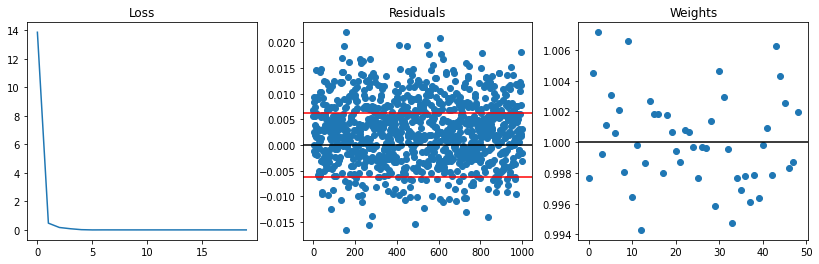

In [110]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mean_absolute_error', optimizer='adam')
hist = model.fit(data, truth, epochs=20, verbose=False, batch_size=1)

pred = model.predict(data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

In [5]:
print(np.max(truth)-np.min(truth))

13.67253886355466


We see that the network correctly finds weights in the neighborhood of $1$.<br>

**Note:** Use MAE instead of MSE, as we want to train for pixel-perfect accuracy which is proportional to absolute error and not to its square. Train for very small `batch_sizes`, best even single-shot training.

# Noisy regression
Now, let's add some noise to each pixel value while regressing to the truth from above.

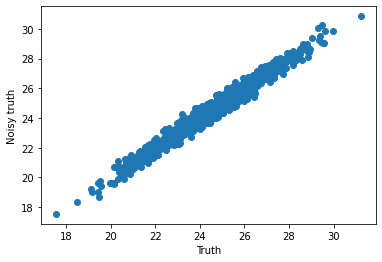

In [10]:
std = 0.05
noisy_data = data + np.random.normal(0,std,size=data.shape)
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

In this case, let std of pixel value $i$ be $\sigma_i$ for $N=n\times n$ total pixel values in an image. Then the std of the sum of pixel values is $\sigma_{tot}=\sqrt{\sum_{i=1}^N{\sigma_i^2}}$. Thus for example for $\sigma=0.05, N=49$ we have $\sigma_{tot}=\sqrt{49\times 0.05^2}=0.35$, which is exactly the value that we get for std of residuals.

Let's do the same regression task as above but using the noisy data instead:

32/32 [==============================] - 0s 727us/step
Standard deviation of residuals: 0.33269240049243787


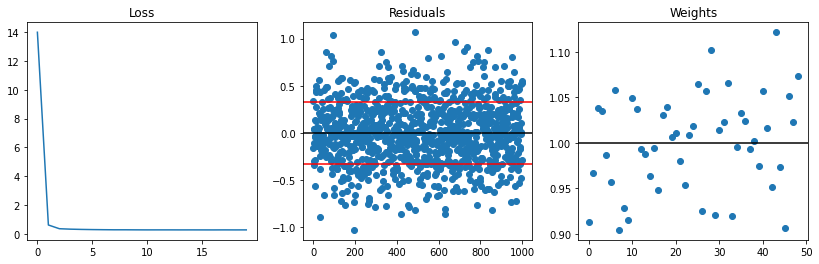

In [11]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mean_absolute_error', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=20, verbose=False, batch_size=1)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

We see that the standard deviation of residuals is very close to $\sigma_{tot}$.

As expected, the predictions are more off. in this case we get a relative error of $\sim \{3.9, 7.8, 15.6, 31.3, ..., \gt 100\}\%$ for std=$\{0.025 0.05, 0.1, 0.2, ..., 1.0\}$, which scales linearly with the spread of the data (i.e. the std of noise). This makes sense, as there is no structure in the noise thus there is nothing to learn here for the network. A deeper network would thus also not be able to learn any more information - this is a hard limit.

# Regression of increasingly noisy data
Let's see how the network performs for data where the std of the noise scales with its pixel sum.

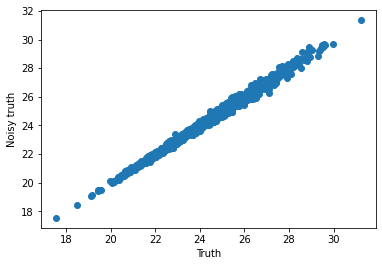

In [12]:
std = (truth-np.min(truth)) / (np.max(truth) - np.min(truth)) * 0.05
noisy_data = data + np.random.normal(0,std[:,None,None], data.shape)
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

And again, train the model.

32/32 [==============================] - 0s 721us/step
Standard deviation of residuals: 0.16815644032658958


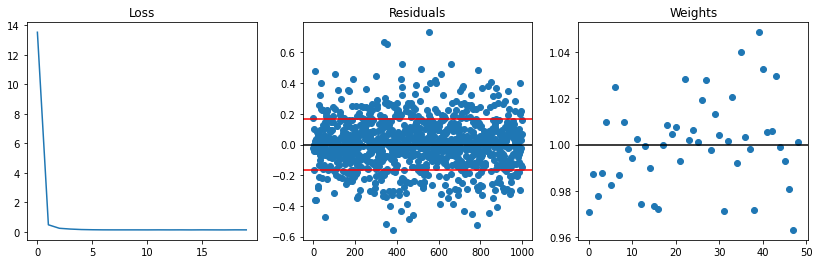

In [113]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mean_absolute_error', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=20, verbose=False, batch_size=1)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

The relative error about halves compared to the case where we applied noise equally to all images. The relative error here again scales linearly with the std of the noise we apply.

Let's also take a look how the std scales with pixel sums (truth):

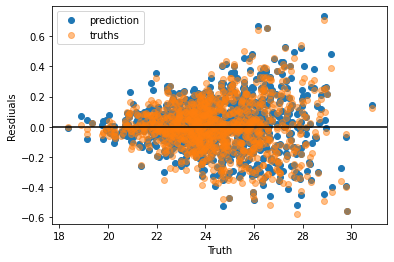

In [138]:
ids = truth.argsort()
sorted_res = pred[ids] - truth[ids]
plt.plot(truth[truth.argsort()], sorted_res, 'o', alpha=1, label='prediction');
plt.plot(truth[ids], noisy_truth[ids] - truth[ids], 'o', alpha=0.5, label='truths');

plt.axhline(0, c='k');
plt.ylabel('Resdiuals');
plt.xlabel('Truth');
plt.legend();

Indeed this last plot shows a very good coincidence between the two residuals noisytruth-truth and predictions-truth. This confirms once again that our network cannot do better then the noise we impose, but it is capable of learning to exactly the regression of increasingly noisy data.

**Result**: For any shallow (or deep) network which maps an input image to a single (fully connected) output neuron we should (with enough training time) be able to learn a function which regresses the pixel sum up to the given std of noise in the data and which scales linearly with the given std. For increasingly noisy data the std of the residuals truth-prediction approximately halves in comparison to "peak" noise over the entire scale. **The main take-away is that the std of the residuals $\hat{y}-y$ and $\tilde{y}-y$ are approximately the same.** (where $y$ is the truth, $\hat{y}$ is the prediction and $\tilde{y}$ is data with (random) noise applied to it.)

# Mapping between representations
Here we are going to take a look at how a shallow network can learn a specific linear map and thereby allows to change representations in the same space ($d_i=d_o$ for $d_{i,o}$ being the dimensions of input and output space, respectively).